In [1]:
import dataset
import models_mae
import numpy as np 
import matplotlib.pyplot as plt
import torch
import timm.optim.optim_factory as optim_factory
from util.misc import NativeScalerWithGradNormCount as NativeScaler
import time
import datetime
from engine_pretrain import train_one_epoch



/home/cnelab-workstation/anaconda3/envs/dreamdiffusion/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/cnelab-workstation/anaconda3/envs/dreamdiffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nfft = 128 
hop_length=16 
spec_size=(64,64)
in_chans = 128
eegdataset = dataset.EggDataset('./dataset/mne_data/', nfft = nfft, hop_length=hop_length, spec_size=spec_size)

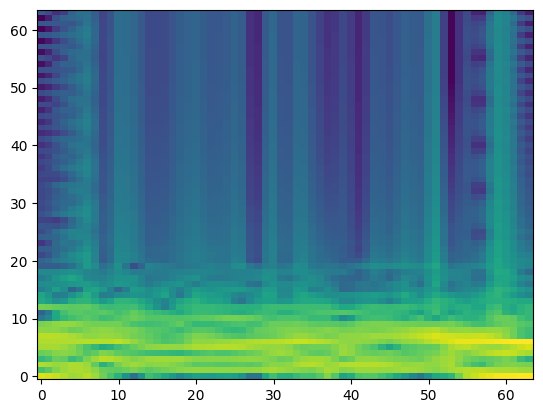

In [3]:
x = eegdataset.__getitem__(0)[0].numpy()
t = np.linspace(0, 5, 512)

_ = plt.imshow(x.squeeze()[11], aspect="auto", origin="lower")

In [4]:
torch.manual_seed(42)
device = torch.device('cuda')
batch_size = 4 
accum_iter = 1
blr = 1e-3
weight_decay = 0.05
epochs = 100

eff_batch_size = batch_size * accum_iter
lr = blr * eff_batch_size / 256

In [5]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = Namespace(accum_iter=1, mask_ratio=0.3, batch_size=batch_size, lr = blr, warmup_epochs=40, min_lr=0., epochs=epochs)

In [6]:
# DatasetLoader

data_loader_train = torch.utils.data.DataLoader(
        eegdataset, sampler=None,
        batch_size=batch_size,
        num_workers=10,
        pin_memory=True,
        drop_last=True,
    )

In [7]:
mask_2d=False
mask_t_prob=0.5
mask_f_prob=0.3
audio_exp=True

maeeeg = models_mae.maeeeg_vit_base_patch4_dec512d8b( in_chans = in_chans, img_size= spec_size, mask_2d=mask_2d,
                                                     mask_t_prob=mask_t_prob, mask_f_prob=mask_f_prob,audio_exp=audio_exp )

maeeeg.to(device)

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(128, 768, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed):

In [8]:
model_without_ddp = maeeeg
print("Model = %s" % str(model_without_ddp))

print("base lr: %.2e" % (lr * 256 / eff_batch_size))
print("actual lr: %.2e" % lr)

print("accumulate grad iterations: %d" % accum_iter)
print("effective batch size: %d" % eff_batch_size)


param_groups = optim_factory.add_weight_decay(model_without_ddp, weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr, betas=(0.9, 0.95))
print(optimizer)
loss_scaler = NativeScaler()

Model = MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(128, 768, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder

In [428]:
maeeeg.to(device)
print(f"Start training for {epochs} epochs")
start_time = time.time()
for epoch in range(0, epochs):
    train_stats = train_one_epoch(
        maeeeg, data_loader_train,
        optimizer, device, epoch, loss_scaler,
        log_writer=None,
        args=args
    )
    # if args.output_dir and (epoch % args.save_every_epoch == 0 or epoch + 1 == args.epochs):
    #     misc.save_model(
    #         args=args, model=model, model_without_ddp=model_without_ddp, optimizer=optimizer,
    #         loss_scaler=loss_scaler, epoch=epoch)

    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                    'epoch': epoch,}

    # if args.output_dir and misc.is_main_process():
    #     if log_writer is not None:
    #         log_writer.flush()
    #     with open(os.path.join(args.output_dir, "log.txt"), mode="a", encoding="utf-8") as f:
    #         f.write(json.dumps(log_stats) + "\n")

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))


Start training for 100 epochs
Epoch: [0]  [   0/2991]  eta: 0:40:37  lr: 0.000000  loss: 8.3069 (8.3069)  time: 0.8148  data: 0.7083  max mem: 1611
Epoch: [0]  [ 200/2991]  eta: 0:03:06  lr: 0.000002  loss: 4.7881 (5.3008)  time: 0.0618  data: 0.0001  max mem: 1611
Epoch: [0]  [ 400/2991]  eta: 0:02:47  lr: 0.000003  loss: 5.1662 (5.1952)  time: 0.0623  data: 0.0001  max mem: 1611
Epoch: [0]  [ 600/2991]  eta: 0:02:33  lr: 0.000005  loss: 7.9986 (5.4407)  time: 0.0613  data: 0.0001  max mem: 1611
Epoch: [0]  [ 800/2991]  eta: 0:02:19  lr: 0.000007  loss: 7.4266 (6.1039)  time: 0.0632  data: 0.0001  max mem: 1611
Epoch: [0]  [1000/2991]  eta: 0:02:07  lr: 0.000008  loss: 5.3579 (6.1061)  time: 0.0629  data: 0.0001  max mem: 1611
Epoch: [0]  [1200/2991]  eta: 0:01:53  lr: 0.000010  loss: 5.1767 (5.9976)  time: 0.0666  data: 0.0001  max mem: 1611
Epoch: [0]  [1400/2991]  eta: 0:01:41  lr: 0.000012  loss: 6.8764 (6.0798)  time: 0.0665  data: 0.0001  max mem: 1611
Epoch: [0]  [1600/2991]  e

In [429]:
maeeeg.to('cpu')

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed_org(
    (proj): Conv2d(128, 768, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed):

In [430]:
x = eegdataset.__getitem__(0)[0]
x.shape

torch.Size([128, 64, 64])

In [439]:
loss, y, mask_, _ = maeeeg(x.unsqueeze(0), 0.7)
print(loss)

tensor(7.4933, grad_fn=<DivBackward0>)


In [452]:
maeeeg.forward_encoder(x.unsqueeze(0), 0.7)[0].shape

torch.Size([1, 77, 768])

In [456]:
(77*768)/512

115.5

In [440]:
y = unpatchify(y, 128)
y = torch.einsum('nchw->nhwc', y).detach().cpu().squeeze()

In [441]:
y.shape

torch.Size([64, 64, 128])

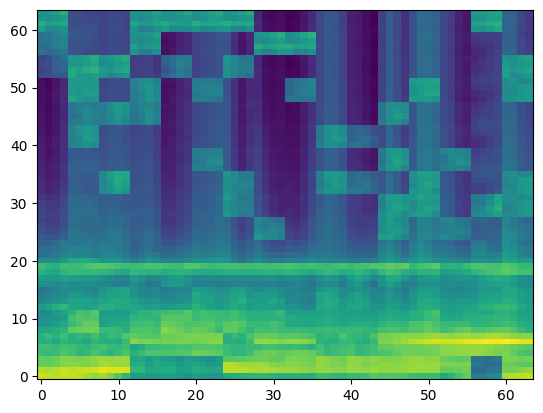

In [442]:

plt.imshow(y[:,:,100], aspect="auto", origin="lower")

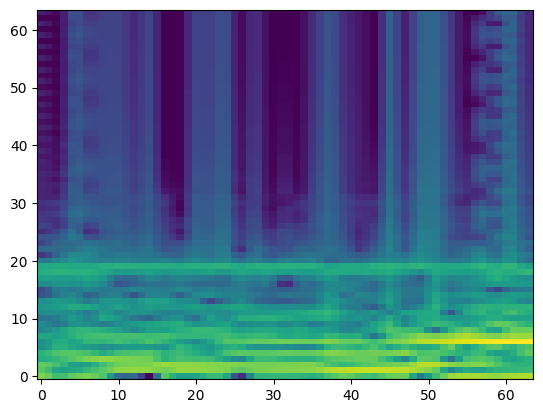

In [443]:
plt.imshow(x[100], aspect="auto", origin="lower")

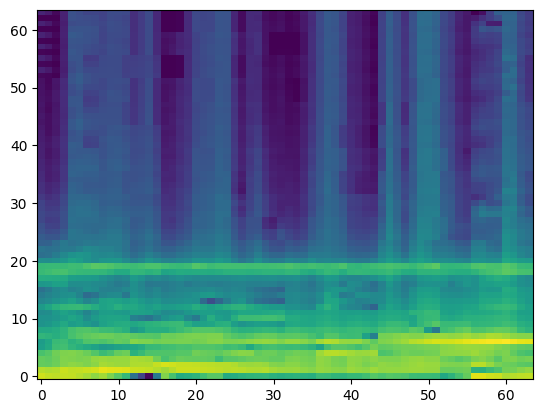

In [448]:
plt.imshow(im_paste.squeeze()[:,:,100], aspect="auto", origin="lower")

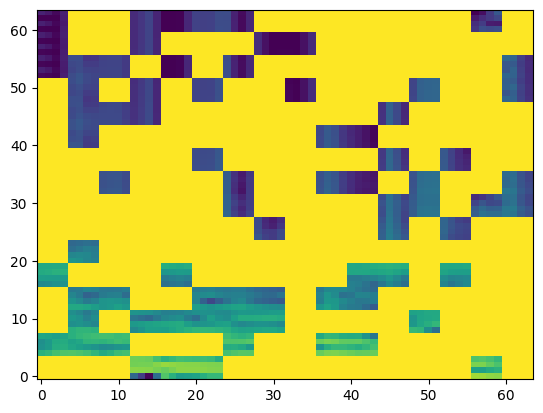

In [446]:
plt.imshow(im_masked.squeeze()[:,:,100], aspect="auto", origin="lower")

In [445]:
mask = mask_.detach()
#mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = mask.unsqueeze(-1).repeat(1, 1, maeeeg.patch_embed.patch_size[0]**2 *128)
print(mask.shape)
mask = unpatchify(mask,128)  # 0 is keep, 1 is remove
print(mask.shape)
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
print(mask.shape)

x_ = torch.einsum('nchw->nhwc', x.unsqueeze(0))
print('x',x.shape)
# masked image
im_masked = x_ * ( 1 - mask) 

im_paste = x_ * (1 - mask) + y * mask

im_masked2 = im_masked + (1 - mask)*-53

torch.Size([1, 256, 2048])
torch.Size([1, 128, 64, 64])
torch.Size([1, 64, 64, 128])
x torch.Size([128, 64, 64])


In [185]:
def unpatchify(x, c=1):
    """
    x: (N, L, patch_size**2 *3)
    specs: (N, 1, H, W)
    """
    p = 4 
    h = 64//p
    w = 64//p
    x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
    x = torch.einsum('nhwpqc->nchpwq', x)
    specs = x.reshape(shape=(x.shape[0], c, h * p, w * p))
    return specs